In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# importing libraries
import math
import pandas as pd
import numpy as np
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap

In [4]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder()

In [5]:
train_path = '/content/drive/MyDrive/Hackathons/Cascade Cup/train.csv'
test_path = '/content/drive/MyDrive/Hackathons/Cascade Cup/test.csv'
sub_path = '/content/drive/MyDrive/Hackathons/Cascade Cup/test.csv'

In [6]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sub = pd.read_csv(sub_path)

print('Train Rows = ',train.shape[0])
print('Train Column = ',train.shape[1])

train.sample(5)

Train Rows =  450000
Train Column =  20


,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
69880,2021-01-27 16:33:08,549528,2021-01-27 00:00:00,2021-01-27 16:34:22,2021-01-27 16:35:27,2021-01-27 16:45:42,2021-01-27 17:02:06,15059,1.010000,2.06,93.0,92.0,0,1.0,1356.0,NaN,NaN,NaN,169.616667,NaN
428224,2021-02-05 16:17:04,189171,2021-02-05 00:00:00,2021-02-05 16:17:22,2021-02-05 16:18:14,2021-02-05 16:34:59,2021-02-05 17:01:16,7307,0.047407,6.05,53.0,52.0,0,1.0,2901.0,NaN,NaN,NaN,180.716667,NaN
54378,2021-01-27 14:09:13,534026,2021-01-27 00:00:00,2021-01-27 14:10:12,2021-01-27 14:10:56,2021-01-27 14:25:05,2021-01-27 15:01:03,10437,0.047358,3.13,215.0,215.0,0,0.0,489.0,NaN,NaN,NaN,28.666667,NaN
31440,2021-01-26 16:32:12,588193,2021-01-26 00:00:00,2021-01-26 16:32:13,2021-01-26 16:32:22,2021-01-26 16:58:32,2021-01-26 17:07:49,17822,0.440700,2.69,29.0,29.0,0,0.0,118.0,NaN,NaN,NaN,182.016667,NaN
383790,2021-02-04 15:50:27,226762,2021-02-04 00:00:00,2021-02-04 15:51:37,2021-02-04 15:51:46,2021-02-04 16:20:45,2021-02-04 16:36:09,2202,2.239600,5.22,157.0,156.0,0,1.0,399.0,NaN,NaN,NaN,342.800000,NaN


In [7]:
train['order_time'] = pd.to_datetime(train['order_time'])
train['order_date'] = pd.to_datetime(train['order_date'])
train['allot_time'] = pd.to_datetime(train['allot_time'])
train['accept_time'] = pd.to_datetime(train['accept_time'])
train['pickup_time'] = pd.to_datetime(train['pickup_time'])
train['delivered_time'] = pd.to_datetime(train['delivered_time'])

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_time            450000 non-null  datetime64[ns]
 1   order_id              450000 non-null  int64         
 2   order_date            450000 non-null  datetime64[ns]
 3   allot_time            450000 non-null  datetime64[ns]
 4   accept_time           449843 non-null  datetime64[ns]
 5   pickup_time           447579 non-null  datetime64[ns]
 6   delivered_time        444782 non-null  datetime64[ns]
 7   rider_id              450000 non-null  int64         
 8   first_mile_distance   450000 non-null  float64       
 9   last_mile_distance    450000 non-null  float64       
 10  alloted_orders        433052 non-null  float64       
 11  delivered_orders      432659 non-null  float64       
 12  cancelled             450000 non-null  int64         
 13 

In [8]:
train[train['cancelled']==1]

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
20,2021-01-26 03:28:13,556773,2021-01-26,2021-01-26 04:09:50,2021-01-26 04:11:06,NaT,NaT,12885,2.8438,6.81,29.0,29.0,1,0.0,449.0,auto,Reassignment Request from SE portal.,1.0,NaN,2021-01-26 04:51:46
68,2021-01-26 03:45:17,556821,2021-01-26,2021-01-26 03:45:18,2021-01-26 03:46:41,NaT,NaT,17557,0.8617,2.63,13.0,13.0,1,0.0,168.0,NaN,NaN,NaN,5.000000,2021-01-26 04:08:50
100,2021-01-26 03:54:11,556853,2021-01-26,2021-01-26 05:29:06,2021-01-26 05:30:01,NaT,NaT,2391,2.9217,5.20,118.0,114.0,1,4.0,860.0,auto,Reassignment Request from SE portal.,1.0,22.516667,2021-01-26 05:45:51
163,2021-01-26 04:11:37,556916,2021-01-26,2021-01-26 04:12:30,2021-01-26 04:12:42,NaT,NaT,15229,2.1287,0.45,55.0,52.0,1,3.0,256.0,NaN,NaN,NaN,92.916667,2021-01-26 05:10:15
295,2021-01-26 04:39:16,557048,2021-01-26,2021-01-26 04:39:50,2021-01-26 04:40:02,NaT,NaT,2373,1.6053,4.84,104.0,104.0,1,0.0,3282.0,NaN,NaN,NaN,9.833333,2021-01-26 04:40:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449738,2021-02-06 09:50:15,129969,2021-02-06,2021-02-06 10:42:09,2021-02-06 10:42:47,NaT,NaT,3027,1.7963,2.00,215.0,214.0,1,1.0,975.0,auto,Reassign,1.0,88.983333,2021-02-06 11:05:48
449922,2021-02-06 09:59:19,130153,2021-02-06,2021-02-06 10:00:14,2021-02-06 10:01:18,2021-02-06 10:19:22,NaT,2344,2.2022,2.56,89.0,88.0,1,1.0,176.0,NaN,NaN,NaN,174.616667,2021-02-06 11:13:48
449928,2021-02-06 09:59:27,130159,2021-02-06,2021-02-06 09:59:28,2021-02-06 10:00:07,2021-02-06 10:09:37,NaT,11998,1.6601,7.50,314.0,312.0,1,2.0,437.0,NaN,NaN,NaN,282.183333,2021-02-06 10:45:49
449932,2021-02-06 09:59:40,130163,2021-02-06,2021-02-06 10:04:41,NaT,NaT,NaT,2583,0.9083,8.39,106.0,106.0,1,0.0,133.0,NaN,NaN,NaN,28.700000,2021-02-06 10:04:41


In [9]:
print('test Rows = ',test.shape[0])
print('test Column = ',test.shape[1])

test.sample(5)

test Rows =  144844
test Column =  16


,order_time,order_id,order_date,allot_time,accept_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time
87724,2021-02-08 15:13:50,64514,2021-02-08 00:00:00,2021-02-08 15:13:52,2021-02-08 15:15:33,5160,1.2103,2.84,112.0,112.0,0.0,131.0,NaN,NaN,NaN,98.383333
80257,2021-02-08 14:07:29,57047,2021-02-08 00:00:00,2021-02-08 14:07:31,2021-02-08 14:07:52,7831,1.2380,3.03,103.0,100.0,3.0,2125.0,NaN,NaN,NaN,359.533333
32806,2021-02-07 08:08:35,86756,2021-02-07 00:00:00,2021-02-07 08:08:35,2021-02-07 08:12:05,375,1.4402,2.96,11.0,11.0,0.0,30.0,NaN,NaN,NaN,98.583333
53097,2021-02-07 15:49:59,107048,2021-02-07 00:00:00,2021-02-07 15:49:59,2021-02-07 15:53:31,8675,0.5717,1.06,127.0,126.0,1.0,228.0,NaN,NaN,NaN,262.016667
25369,2021-02-06 17:42:28,155600,2021-02-06 00:00:00,2021-02-06 17:42:29,2021-02-06 17:43:31,7512,2.3573,2.45,153.0,152.0,1.0,759.0,NaN,NaN,NaN,134.016667


In [10]:
test['order_time'] = pd.to_datetime(test['order_time'])
test['order_date'] = pd.to_datetime(test['order_date'])
test['allot_time'] = pd.to_datetime(test['allot_time'])
test['accept_time'] = pd.to_datetime(test['accept_time'])

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_time            144844 non-null  datetime64[ns]
 1   order_id              144844 non-null  int64         
 2   order_date            144844 non-null  datetime64[ns]
 3   allot_time            144844 non-null  datetime64[ns]
 4   accept_time           144776 non-null  datetime64[ns]
 5   rider_id              144844 non-null  int64         
 6   first_mile_distance   144844 non-null  float64       
 7   last_mile_distance    144844 non-null  float64       
 8   alloted_orders        140071 non-null  float64       
 9   delivered_orders      139960 non-null  float64       
 10  undelivered_orders    139960 non-null  float64       
 11  lifetime_order_count  144066 non-null  float64       
 12  reassignment_method   4632 non-null    object        
 13 

In [11]:
## Train columns not in Test column

set(train.columns.values) - set(test.columns.values)

{'cancelled', 'cancelled_time', 'delivered_time', 'pickup_time'}

### In the Process of Combining Train and Test

In [12]:
nan = test['reassignment_reason'][0]
test['cancelled'] = nan

In [13]:
train = train.drop(['cancelled_time', 'delivered_time', 'pickup_time'],axis=1)

cancelled_column = train.pop('cancelled')
train.insert(16, 'cancelled', cancelled_column)

In [14]:
train.head(5)

,order_time,order_id,order_date,allot_time,accept_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled
0,2021-01-26 02:21:35,556753,2021-01-26,2021-01-26 02:21:59,2021-01-26 02:22:08,11696,1.5666,2.65,46.0,46.0,0.0,621.0,NaN,NaN,NaN,NaN,0
1,2021-01-26 02:33:16,556754,2021-01-26,2021-01-26 02:33:57,2021-01-26 02:34:45,18117,2.5207,2.76,8.0,8.0,0.0,105.0,NaN,NaN,NaN,3.266667,0
2,2021-01-26 02:39:49,556755,2021-01-26,2021-01-26 02:39:57,2021-01-26 02:40:13,18623,2.2074,4.80,1.0,1.0,0.0,66.0,NaN,NaN,NaN,9.816667,0
3,2021-01-26 02:47:53,556756,2021-01-26,2021-01-26 02:48:25,2021-01-26 02:49:06,15945,2.1894,6.38,1.0,1.0,0.0,127.0,NaN,NaN,NaN,17.533333,0
4,2021-01-26 03:06:30,556757,2021-01-26,2021-01-26 03:07:21,2021-01-26 03:07:57,17589,2.7870,4.01,34.0,34.0,0.0,84.0,NaN,NaN,NaN,1.350000,0


In [15]:
test.head(5)

,order_time,order_id,order_date,allot_time,accept_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled
0,2021-02-06 10:03:24,130231,2021-02-06,2021-02-06 10:03:49,2021-02-06 10:04:15,12884,1.6585,4.54,216.0,215.0,1.0,747.0,NaN,NaN,NaN,273.400000,NaN
1,2021-02-06 10:03:26,130232,2021-02-06,2021-02-06 10:03:27,2021-02-06 10:03:36,3541,2.0709,5.84,52.0,52.0,0.0,75.0,NaN,NaN,NaN,252.100000,NaN
2,2021-02-06 10:03:27,130233,2021-02-06,2021-02-06 10:04:14,2021-02-06 10:05:34,603,1.3884,0.99,289.0,289.0,0.0,2214.0,NaN,NaN,NaN,241.383333,NaN
3,2021-02-06 10:03:29,130234,2021-02-06,2021-02-06 10:03:30,2021-02-06 10:03:53,3414,1.9039,2.59,125.0,122.0,3.0,1020.0,NaN,NaN,NaN,291.933333,NaN
4,2021-02-06 10:03:35,130235,2021-02-06,2021-02-06 10:03:43,2021-02-06 10:04:43,1426,0.8275,0.94,352.0,350.0,2.0,7284.0,NaN,NaN,NaN,247.133333,NaN


In [16]:
combo = pd.concat([train,test])
combo.head(5)

,order_time,order_id,order_date,allot_time,accept_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled
0,2021-01-26 02:21:35,556753,2021-01-26,2021-01-26 02:21:59,2021-01-26 02:22:08,11696,1.5666,2.65,46.0,46.0,0.0,621.0,NaN,NaN,NaN,NaN,0.0
1,2021-01-26 02:33:16,556754,2021-01-26,2021-01-26 02:33:57,2021-01-26 02:34:45,18117,2.5207,2.76,8.0,8.0,0.0,105.0,NaN,NaN,NaN,3.266667,0.0
2,2021-01-26 02:39:49,556755,2021-01-26,2021-01-26 02:39:57,2021-01-26 02:40:13,18623,2.2074,4.80,1.0,1.0,0.0,66.0,NaN,NaN,NaN,9.816667,0.0
3,2021-01-26 02:47:53,556756,2021-01-26,2021-01-26 02:48:25,2021-01-26 02:49:06,15945,2.1894,6.38,1.0,1.0,0.0,127.0,NaN,NaN,NaN,17.533333,0.0
4,2021-01-26 03:06:30,556757,2021-01-26,2021-01-26 03:07:21,2021-01-26 03:07:57,17589,2.7870,4.01,34.0,34.0,0.0,84.0,NaN,NaN,NaN,1.350000,0.0


### Doing Some Data Wrangling Now

In [17]:
train.isnull().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                157
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders           16948
delivered_orders         17341
undelivered_orders       17341
lifetime_order_count        53
reassignment_method     436256
reassignment_reason     436247
reassigned_order        436247
session_time              3675
cancelled                    0
dtype: int64

In [18]:
test.isnull().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                 68
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders            4773
delivered_orders          4884
undelivered_orders        4884
lifetime_order_count       778
reassignment_method     140212
reassignment_reason     140209
reassigned_order        140209
session_time              5054
cancelled               144844
dtype: int64

In [19]:
combo.shape

(594844, 17)

In [20]:
cont_feats = [x for x in combo.select_dtypes('float64').drop('cancelled',axis=1).columns]
cont_feats

['first_mile_distance',
 'last_mile_distance',
 'alloted_orders',
 'delivered_orders',
 'undelivered_orders',
 'lifetime_order_count',
 'reassigned_order',
 'session_time']

In [21]:
combo['reassigned_order'].value_counts()

1.0    18388
Name: reassigned_order, dtype: int64

In [22]:
from sklearn.preprocessing import QuantileTransformer

for col in ['first_mile_distance', 'last_mile_distance', 'alloted_orders','delivered_orders', 'lifetime_order_count', 'session_time']:
  quantile = QuantileTransformer(output_distribution='normal')
  combo[col] = quantile.fit_transform(combo[col].values.reshape(-1, 1))

In [23]:
combo['reassignment_reason'].value_counts()

Auto Reassignment basis Inaction. coreengine.tasks.repush_order_to_aa_bucket    9805
Reassignment Request from SE portal.                                            6882
Reassign                                                                        1701
Name: reassignment_reason, dtype: int64

### Dealing With So - many Missing Values

In [24]:
cat_cols = ['reassignment_reason','reason_text','user_type']

In [25]:


# combo['reassignment_method'] = le.fit_transform(combo['reassignment_method'].astype(str))
# combo['reassignment_reason'] = le.fit_transform(combo['reassignment_reason'].astype(str))       


combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594844 entries, 0 to 144843
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_time            594844 non-null  datetime64[ns]
 1   order_id              594844 non-null  int64         
 2   order_date            594844 non-null  datetime64[ns]
 3   allot_time            594844 non-null  datetime64[ns]
 4   accept_time           594619 non-null  datetime64[ns]
 5   rider_id              594844 non-null  int64         
 6   first_mile_distance   594844 non-null  float64       
 7   last_mile_distance    594844 non-null  float64       
 8   alloted_orders        573123 non-null  float64       
 9   delivered_orders      572619 non-null  float64       
 10  undelivered_orders    572619 non-null  float64       
 11  lifetime_order_count  594013 non-null  float64       
 12  reassignment_method   18376 non-null   object        
 13 

In [26]:
combo.isnull().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                225
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders           21721
delivered_orders         22225
undelivered_orders       22225
lifetime_order_count       831
reassignment_method     576468
reassignment_reason     576456
reassigned_order        576456
session_time              8729
cancelled               144844
dtype: int64

In [27]:
combo['reassigned_order'].value_counts()

1.0    18388
Name: reassigned_order, dtype: int64

In [28]:

combo['alloted_orders'] = combo['alloted_orders'].fillna(0)
combo['delivered_orders'] = combo['delivered_orders'].fillna(0)
combo['undelivered_orders'] = combo['undelivered_orders'].fillna(0)

combo['lifetime_order_count'] = combo['lifetime_order_count'].fillna(0)

combo['reassigned_order'] = combo['reassigned_order'].fillna(0)
combo['session_time'] = combo['session_time'].fillna(0)

In [29]:
combo.isnull().sum()

order_time                   0
order_id                     0
order_date                   0
allot_time                   0
accept_time                225
rider_id                     0
first_mile_distance          0
last_mile_distance           0
alloted_orders               0
delivered_orders             0
undelivered_orders           0
lifetime_order_count         0
reassignment_method     576468
reassignment_reason     576456
reassigned_order             0
session_time                 0
cancelled               144844
dtype: int64

In [30]:
combo['order_hour'] = combo['order_time'].dt.hour
combo['order_minute'] = combo['order_time'].dt.minute
combo['order_day_of_week'] = combo['order_date'].dt.dayofweek
combo["Is Weekend"] = le.fit_transform(combo['order_day_of_week']> 4)

# combo['diff_oder_allot_hour'] = (combo['order_date'] -  combo['allot_time'] ).dt.hour
combo['diff_oder_allot_minute'] = (combo['allot_time'] -  combo['order_time'] ).dt.total_seconds()/60   

# combo['diff_accept_allot_hour'] = (combo['allot_time'] -  combo['accept_time'] ).dt.hour
combo['diff_accept_allot_minute'] = (combo['accept_time'] -  combo['allot_time'] ).dt.total_seconds()/60

In [31]:
combo = combo.drop(['order_time','order_date','allot_time','accept_time'],axis=1)
combo.head(5)

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled,order_hour,order_minute,order_day_of_week,Is Weekend,diff_oder_allot_minute,diff_accept_allot_minute
0,556753,11696,0.391890,0.005018,-0.502074,-0.499230,0.0,0.360172,NaN,NaN,0.0,0.000000,0.0,2,21,1,0,0.400000,0.150000
1,556754,18117,1.376171,0.055229,-1.550085,-1.566990,0.0,-0.983573,NaN,NaN,0.0,-1.906909,0.0,2,33,1,0,0.683333,0.800000
2,556755,18623,1.006211,0.949547,-5.199338,-5.199338,0.0,-1.315958,NaN,NaN,0.0,-1.628553,0.0,2,39,1,0,0.133333,0.266667
3,556756,15945,0.986825,1.733071,-5.199338,-5.199338,0.0,-0.842694,NaN,NaN,0.0,-1.469790,0.0,2,47,1,0,0.533333,0.683333
4,556757,17589,1.749208,0.589456,-0.716839,-0.716839,0.0,-1.147315,NaN,NaN,0.0,-2.144011,0.0,3,6,1,0,0.850000,0.600000


In [32]:
combo['indicator_diff_accept_allot_minute'] = combo['diff_accept_allot_minute'] .isnull()

combo['diff_accept_allot_minute'] = combo['diff_accept_allot_minute'].fillna(0)

combo['reassignment_method'] = le.fit_transform(combo['reassignment_method'].astype(str))
combo['reassignment_reason'] = le.fit_transform(combo['reassignment_reason'].astype(str))       

combo['indicator_diff_accept_allot_minute'] = le.fit_transform(combo['indicator_diff_accept_allot_minute'].astype(str))  

# combo = combo.drop('alloted_orders',axis=1)

# OHE

# a = pd.get_dummies(combo['reassignment_method'].astype(str), prefix='reassignment_method',drop_first=True)
# b = pd.get_dummies(combo['reassignment_reason'].astype(str), prefix='reassignment_reasona',drop_first=True)
# combo = combo.drop(['reassignment_method','reassignment_reason'],axis=1)
# combo = pd.concat([combo,a,b],axis=1)
combo

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled,order_hour,order_minute,order_day_of_week,Is Weekend,diff_oder_allot_minute,diff_accept_allot_minute,indicator_diff_accept_allot_minute
0,556753,11696,0.391890,0.005018,-0.502074,-0.499230,0.0,0.360172,2,3,0.0,0.000000,0.0,2,21,1,0,0.400000,0.150000,0
1,556754,18117,1.376171,0.055229,-1.550085,-1.566990,0.0,-0.983573,2,3,0.0,-1.906909,0.0,2,33,1,0,0.683333,0.800000,0
2,556755,18623,1.006211,0.949547,-5.199338,-5.199338,0.0,-1.315958,2,3,0.0,-1.628553,0.0,2,39,1,0,0.133333,0.266667,0
3,556756,15945,0.986825,1.733071,-5.199338,-5.199338,0.0,-0.842694,2,3,0.0,-1.469790,0.0,2,47,1,0,0.533333,0.683333,0
4,556757,17589,1.749208,0.589456,-0.716839,-0.716839,0.0,-1.147315,2,3,0.0,-2.144011,0.0,3,6,1,0,0.850000,0.600000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144839,41184,7141,0.253063,0.567211,-0.406079,-0.401995,0.0,0.048948,2,3,0.0,0.004567,NaN,20,13,1,0,0.016667,0.150000,0
144840,41185,8113,-0.406816,-0.551076,0.158740,0.140977,2.0,-0.232930,2,3,0.0,0.388635,NaN,20,21,1,0,0.383333,0.566667,0
144841,41186,5040,0.844892,-0.814401,-0.056486,-0.051460,0.0,-0.886449,2,3,0.0,0.457637,NaN,20,24,1,0,0.633333,1.116667,0
144842,41187,2946,-1.530295,1.286702,1.295363,1.286702,3.0,1.200317,2,3,0.0,2.894837,NaN,20,28,1,0,0.366667,0.400000,0


## Preparing The Data to be Modelled

In [33]:
train = combo[combo['cancelled'].isnull() == False]
test = (combo[combo['cancelled'].isnull() == True].reset_index()).drop(['index','cancelled'],axis=1)

In [34]:
train

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled,order_hour,order_minute,order_day_of_week,Is Weekend,diff_oder_allot_minute,diff_accept_allot_minute,indicator_diff_accept_allot_minute
0,556753,11696,0.391890,0.005018,-0.502074,-0.499230,0.0,0.360172,2,3,0.0,0.000000,0.0,2,21,1,0,0.400000,0.150000,0
1,556754,18117,1.376171,0.055229,-1.550085,-1.566990,0.0,-0.983573,2,3,0.0,-1.906909,0.0,2,33,1,0,0.683333,0.800000,0
2,556755,18623,1.006211,0.949547,-5.199338,-5.199338,0.0,-1.315958,2,3,0.0,-1.628553,0.0,2,39,1,0,0.133333,0.266667,0
3,556756,15945,0.986825,1.733071,-5.199338,-5.199338,0.0,-0.842694,2,3,0.0,-1.469790,0.0,2,47,1,0,0.533333,0.683333,0
4,556757,17589,1.749208,0.589456,-0.716839,-0.716839,0.0,-1.147315,2,3,0.0,-2.144011,0.0,3,6,1,0,0.850000,0.600000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449995,130226,1006,-0.652647,-2.023292,-1.918441,-1.951050,0.0,-0.842694,2,3,0.0,0.811029,0.0,10,3,5,1,0.466667,0.500000,0
449996,130227,279,0.782856,-0.869846,-0.006273,-0.001255,0.0,-0.983573,2,3,0.0,0.361173,0.0,10,3,5,1,0.016667,1.266667,0
449997,130228,3161,0.417334,-0.551076,-0.846279,-0.846279,0.0,1.054355,2,3,0.0,0.161428,0.0,10,3,5,1,0.800000,0.550000,0
449998,130229,9396,1.985625,0.892038,-0.121995,-0.118204,0.0,-0.983573,2,3,0.0,-0.854744,0.0,10,3,5,1,0.000000,2.366667,0


In [35]:
train['cancelled'] = train['cancelled'].astype(int)
print('Train Rows',train.shape[0])
print('Train Cols',train.shape[1])
train.head(5)

Train Rows 450000
Train Cols 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled,order_hour,order_minute,order_day_of_week,Is Weekend,diff_oder_allot_minute,diff_accept_allot_minute,indicator_diff_accept_allot_minute
0,556753,11696,0.391890,0.005018,-0.502074,-0.499230,0.0,0.360172,2,3,0.0,0.000000,0,2,21,1,0,0.400000,0.150000,0
1,556754,18117,1.376171,0.055229,-1.550085,-1.566990,0.0,-0.983573,2,3,0.0,-1.906909,0,2,33,1,0,0.683333,0.800000,0
2,556755,18623,1.006211,0.949547,-5.199338,-5.199338,0.0,-1.315958,2,3,0.0,-1.628553,0,2,39,1,0,0.133333,0.266667,0
3,556756,15945,0.986825,1.733071,-5.199338,-5.199338,0.0,-0.842694,2,3,0.0,-1.469790,0,2,47,1,0,0.533333,0.683333,0
4,556757,17589,1.749208,0.589456,-0.716839,-0.716839,0.0,-1.147315,2,3,0.0,-2.144011,0,3,6,1,0,0.850000,0.600000,0


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450000 entries, 0 to 449999
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   order_id                            450000 non-null  int64  
 1   rider_id                            450000 non-null  int64  
 2   first_mile_distance                 450000 non-null  float64
 3   last_mile_distance                  450000 non-null  float64
 4   alloted_orders                      450000 non-null  float64
 5   delivered_orders                    450000 non-null  float64
 6   undelivered_orders                  450000 non-null  float64
 7   lifetime_order_count                450000 non-null  float64
 8   reassignment_method                 450000 non-null  int64  
 9   reassignment_reason                 450000 non-null  int64  
 10  reassigned_order                    450000 non-null  float64
 11  session_time              

In [37]:
# train = train[train['diff_accept_allot_minute'] .isnull() == False]

In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 19 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   order_id                            144844 non-null  int64  
 1   rider_id                            144844 non-null  int64  
 2   first_mile_distance                 144844 non-null  float64
 3   last_mile_distance                  144844 non-null  float64
 4   alloted_orders                      144844 non-null  float64
 5   delivered_orders                    144844 non-null  float64
 6   undelivered_orders                  144844 non-null  float64
 7   lifetime_order_count                144844 non-null  float64
 8   reassignment_method                 144844 non-null  int64  
 9   reassignment_reason                 144844 non-null  int64  
 10  reassigned_order                    144844 non-null  float64
 11  session_time              

In [39]:
print('Test Rows',test.shape[0])
print('Test Cols',test.shape[1])
test.head(5)

Test Rows 144844
Test Cols 19


,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,order_hour,order_minute,order_day_of_week,Is Weekend,diff_oder_allot_minute,diff_accept_allot_minute,indicator_diff_accept_allot_minute
0,130231,12884,0.475461,0.828465,1.189522,1.194628,1.0,0.491004,2,3,0.0,0.516510,10,3,5,1,0.416667,0.433333,0
1,130232,3541,0.866085,1.490335,-0.406079,-0.401995,0.0,-1.228607,2,3,0.0,0.425843,10,3,5,1,0.016667,0.150000,0
2,130233,603,0.226108,-1.050924,1.644369,1.664082,0.0,1.371657,2,3,0.0,0.373687,10,3,5,1,0.783333,1.333333,0
3,130234,3414,0.704697,-0.022584,0.472407,0.448692,3.0,0.745402,2,3,0.0,0.572352,10,3,5,1,0.016667,0.383333,0
4,130235,1426,-0.353041,-1.102440,2.039755,2.060270,2.0,2.349596,2,3,0.0,0.401595,10,3,5,1,0.133333,1.000000,0


In [40]:
train.columns

Index(['order_id', 'rider_id', 'first_mile_distance', 'last_mile_distance',
       'alloted_orders', 'delivered_orders', 'undelivered_orders',
       'lifetime_order_count', 'reassignment_method', 'reassignment_reason',
       'reassigned_order', 'session_time', 'cancelled', 'order_hour',
       'order_minute', 'order_day_of_week', 'Is Weekend',
       'diff_oder_allot_minute', 'diff_accept_allot_minute',
       'indicator_diff_accept_allot_minute'],
      dtype='object')

In [41]:
order_id = test.order_id
rider_id = test.rider_id

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()


X = train.drop(['order_id','cancelled','rider_id'],axis=1).values  # 
y = train['cancelled']

# X = sc.fit_transform(X)

test = test.drop(['order_id','rider_id'],axis=1) # 

# test = sc.transform(test)

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2084)

### Modelling

*   xgbc - 0.7541642913048924
*   cbc - 0.7540326019372615
*   blend [ 0.47 * cbc + 0.53 * xgbc ] - 0.7572990797120587

In [43]:
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

xgb

In [44]:
!pip install xgboost==0.90

In [45]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score



xgbc = XGBClassifier(n_estimators=109, scale_pos_weight= 87.8842126062043,eval_metric=['auc'])


xgbc.fit(x_train,y_train,eval_set=[[x_train,y_train],[x_test,y_test]])

y_test_preds = xgbc.predict_proba(x_test)

check_arr_xgbc =[]
for i in range(y_test_preds.shape[0]):
    check_arr_xgbc.append(y_test_preds[i][1])
    
print(roc_auc_score(y_test, check_arr_xgbc))

[0]	validation_0-auc:0.671167	validation_1-auc:0.674195
[1]	validation_0-auc:0.684807	validation_1-auc:0.682249
[2]	validation_0-auc:0.689985	validation_1-auc:0.684288
[3]	validation_0-auc:0.703926	validation_1-auc:0.702132
[4]	validation_0-auc:0.703629	validation_1-auc:0.701821
[5]	validation_0-auc:0.710582	validation_1-auc:0.71039
[6]	validation_0-auc:0.711471	validation_1-auc:0.71029
[7]	validation_0-auc:0.713264	validation_1-auc:0.712814
[8]	validation_0-auc:0.723606	validation_1-auc:0.723729
[9]	validation_0-auc:0.724382	validation_1-auc:0.722681
[10]	validation_0-auc:0.727857	validation_1-auc:0.726666
[11]	validation_0-auc:0.728023	validation_1-auc:0.726607
[12]	validation_0-auc:0.729409	validation_1-auc:0.728281
[13]	validation_0-auc:0.731409	validation_1-auc:0.729669
[14]	validation_0-auc:0.733957	validation_1-auc:0.730308
[15]	validation_0-auc:0.733994	validation_1-auc:0.730333
[16]	validation_0-auc:0.734532	validation_1-auc:0.730349
[17]	validation_0-auc:0.734865	validation_1

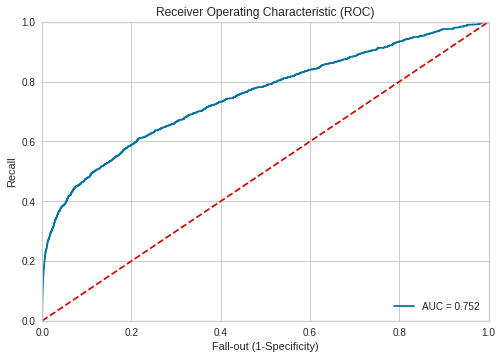

In [46]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test, check_arr_xgbc)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

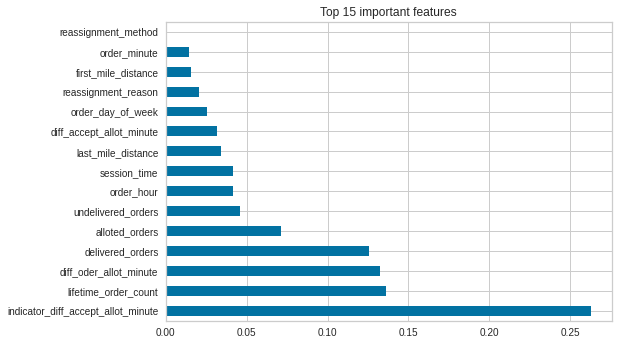

In [47]:
feat_importances = pd.Series(xgbc.feature_importances_, index=test.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

cbc

In [48]:
!pip install catboost==1.0.4

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [49]:
new_cbc_params = {'nan_mode': 'Min', 'eval_metric': 'Logloss', 'iterations': 126,
                  'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton',
                  'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1,
                  'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 
                  'feature_border_type': 'GreedyLogSum',
                   'l2_leaf_reg': 4,
                  'random_strength': 0.20000000298023224, 'rsm': 1, 'boost_from_average': False,
                  'model_size_reg': 0.5,  'subsample': 0.800000011920929, 
                  'use_best_model': False, 'class_names': [0, 1], 'random_seed': 22, 'depth': 4,
                  'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None',
                  'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 
                  'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Logloss',
                  'learning_rate': 0.4000000059604645, 'score_function': 'Cosine', 'task_type': 'CPU',
                  'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 16 ,'eval_metric':'AUC'}

In [50]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

cbc = CatBoostClassifier(**new_cbc_params) 

cbc.fit(x_train,y_train,eval_set=(x_test,y_test))

y_test_preds = cbc.predict_proba(x_test)

check_arr_cbc =[]
for i in range(y_test_preds.shape[0]):
    check_arr_cbc.append(y_test_preds[i][1])
    
print(roc_auc_score(y_test, check_arr_cbc))

0:	test: 0.6121048	best: 0.6121048 (0)	total: 95.3ms	remaining: 11.9s
1:	test: 0.6260635	best: 0.6260635 (1)	total: 134ms	remaining: 8.28s
2:	test: 0.6596141	best: 0.6596141 (2)	total: 176ms	remaining: 7.23s
3:	test: 0.6627140	best: 0.6627140 (3)	total: 217ms	remaining: 6.62s
4:	test: 0.6693791	best: 0.6693791 (4)	total: 263ms	remaining: 6.35s
5:	test: 0.6712108	best: 0.6712108 (5)	total: 330ms	remaining: 6.6s
6:	test: 0.6713228	best: 0.6713228 (6)	total: 440ms	remaining: 7.48s
7:	test: 0.6719120	best: 0.6719120 (7)	total: 530ms	remaining: 7.81s
8:	test: 0.6801200	best: 0.6801200 (8)	total: 612ms	remaining: 7.95s
9:	test: 0.6808711	best: 0.6808711 (9)	total: 652ms	remaining: 7.57s
10:	test: 0.6888374	best: 0.6888374 (10)	total: 692ms	remaining: 7.24s
11:	test: 0.6885934	best: 0.6888374 (10)	total: 739ms	remaining: 7.01s
12:	test: 0.7012446	best: 0.7012446 (12)	total: 779ms	remaining: 6.77s
13:	test: 0.7222219	best: 0.7222219 (13)	total: 838ms	remaining: 6.7s
14:	test: 0.7265353	best: 0

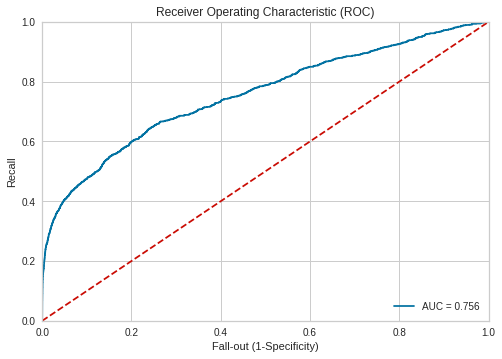

In [51]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_test, check_arr_cbc)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

In [52]:
# save the model to disk
import joblib
# filename = 'cbc_0.77092_model.sav'
# joblib.dump(cbc, filename)
 
# # some time later...
 
# # load the model from disk
# cbc = joblib.load(filename)

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
gdb = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.05, loss='deviance', max_depth=4,
                            max_features='sqrt', max_leaf_nodes=None,
                            min_impurity_decrease=0.5, 
                            min_samples_leaf=5, min_samples_split=9,
                            min_weight_fraction_leaf=0.0, n_estimators=300,
                            n_iter_no_change=None,
                            random_state=22, subsample=0.35, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False)
gdb.fit(x_train,y_train)

y_test_preds = gdb.predict_proba(x_test)

check_arr_gdb =[]
for i in range(y_test_preds.shape[0]):
    check_arr_gdb.append(y_test_preds[i][1])
    
print(roc_auc_score(y_test, check_arr_gdb))

0.7248825789546134


In [54]:
# from sklearn.ensemble import BaggingClassifier
# bgg_cbc = BaggingClassifier(base_estimator=CatBoostClassifier(**new_cbc_params),
#                             n_estimators=10,random_state=42)
# bgg_cbc.fit(x_train,y_train)

# y_test_preds = bgg_cbc.predict_proba(x_test)

# check_arr_bgg_cbc =[]
# for i in range(y_test_preds.shape[0]):
#     check_arr_bgg_cbc.append(y_test_preds[i][1])
    
# print(roc_auc_score(y_test, check_arr_bgg_cbc))

In [55]:
# false_positive_rate, recall, thresholds = roc_curve(y_test, check_arr_bgg_cbc)
# roc_auc = auc(false_positive_rate, recall)
# plt.figure()
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1], [0,1], 'r--')
# plt.xlim([0.0,1.0])
# plt.ylim([0.0,1.0])
# plt.ylabel('Recall')
# plt.xlabel('Fall-out (1-Specificity)')
# plt.show()

In [58]:
from sklearn.ensemble import StackingClassifier
stk = StackingClassifier([
                         ('gdb', GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.05, loss='deviance', max_depth=4,
                            max_features='sqrt', max_leaf_nodes=None,
                            min_impurity_decrease=0.5,
                            min_samples_leaf=5, min_samples_split=9,
                            min_weight_fraction_leaf=0.0, n_estimators=300,
                            n_iter_no_change=None, 
                            random_state=22, subsample=0.35, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False)),('cbc' , CatBoostClassifier(**new_cbc_params))])
stk.fit(x_train,y_train)



0:	total: 33ms	remaining: 4.12s
1:	total: 59.8ms	remaining: 3.71s
2:	total: 87.9ms	remaining: 3.6s
3:	total: 114ms	remaining: 3.49s
4:	total: 140ms	remaining: 3.39s
5:	total: 167ms	remaining: 3.33s
6:	total: 193ms	remaining: 3.28s
7:	total: 222ms	remaining: 3.27s
8:	total: 258ms	remaining: 3.35s
9:	total: 288ms	remaining: 3.34s
10:	total: 315ms	remaining: 3.3s
11:	total: 349ms	remaining: 3.32s
12:	total: 376ms	remaining: 3.27s
13:	total: 406ms	remaining: 3.25s
14:	total: 437ms	remaining: 3.23s
15:	total: 471ms	remaining: 3.24s
16:	total: 498ms	remaining: 3.19s
17:	total: 526ms	remaining: 3.15s
18:	total: 556ms	remaining: 3.13s
19:	total: 592ms	remaining: 3.13s
20:	total: 622ms	remaining: 3.11s
21:	total: 662ms	remaining: 3.13s
22:	total: 705ms	remaining: 3.16s
23:	total: 738ms	remaining: 3.13s
24:	total: 767ms	remaining: 3.1s
25:	total: 795ms	remaining: 3.06s
26:	total: 827ms	remaining: 3.03s
27:	total: 859ms	remaining: 3.01s
28:	total: 889ms	remaining: 2.97s
29:	total: 920ms	remaining

StackingClassifier(estimators=[('gdb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=4,
                                                           max_features='sqrt',
                                                           min_impurity_decrease=0.5,
                                                           min_samples_leaf=5,
                                                           min_samples_split=9,
                                                           n_estimators=300,
                                                           random_state=22,
                                                           subsample=0.35)),
                               ('cbc',
                                <catboost.core.CatBoostClassifier object at 0x7f23abb0ed90>)])

In [59]:
y_test_preds = stk.predict_proba(x_test)

check_arr_stk =[]
for i in range(y_test_preds.shape[0]):
    check_arr_stk.append(y_test_preds[i][1])
    
print(roc_auc_score(y_test, check_arr_stk))

0.7571489559865061


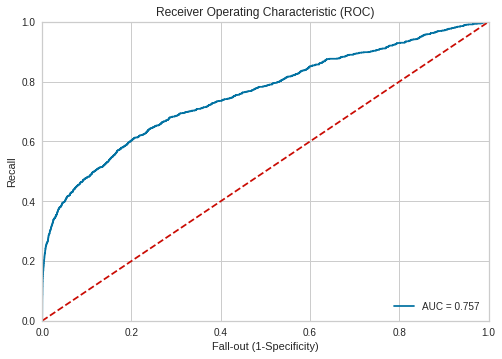

In [60]:
false_positive_rate, recall, thresholds = roc_curve(y_test, check_arr_stk)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

In [61]:
# import joblib
# filename = 'stack_model.sav'
# joblib.dump(stk, filename)
 
# # some time later...
 
# # load the model from disk
# stk = joblib.load(filename)

In [62]:
x = 0.60*(np.array(check_arr_stk)) + 0.35*(np.array(check_arr_cbc)) +0.05*(np.array(check_arr_xgbc))

In [63]:
print(roc_auc_score(y_test,x))

0.7555735290545293


In [64]:
print(roc_auc_score(y_test, (0.45*(np.array(check_arr_stk)) + 0.55*(np.array(check_arr_cbc)))))

0.756276705053202


In [65]:
print(roc_auc_score(y_test, (0.47*(np.array(check_arr_cbc)) + 0.53*(np.array(check_arr_xgbc)))))

0.7531202196651873


In [66]:
print(roc_auc_score(y_test, (0.53*(np.array(check_arr_stk)) + 0.47*(np.array(check_arr_cbc)))))

0.7563276364276005


In [67]:
print(roc_auc_score(y_test, (0.9*(np.array(check_arr_stk)) + 0.1*(np.array(check_arr_cbc)))))

0.7568766077301293


### Making Prediction File

In [68]:
sub = (0.55*cbc.predict_proba(test.values) + 0.45*stk.predict_proba(test.values)) #  ,decimals = 3)
sub_arr =[]
for i in range(sub.shape[0]):
    sub_arr.append(sub[i][1])

submission_df = pd.DataFrame({'order_id':order_id,'cancelled':sub_arr})
submission_df

,order_id,cancelled
0,130231,0.007027
1,130232,0.007580
2,130233,0.005623
3,130234,0.007302
4,130235,0.005393
...,...,...
144839,41184,0.008175
144840,41185,0.008176
144841,41186,0.008230
144842,41187,0.008726


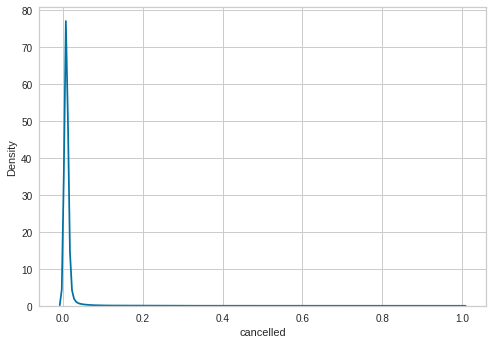

In [69]:
sns.kdeplot(submission_df['cancelled'])

In [70]:
test_new = pd.read_csv(test_path)
submission_df['accept_time'] = test_new['accept_time']
submission_df['cancelled'][submission_df['accept_time'].isnull() == True] = 1
submission_df = submission_df.drop('accept_time',axis=1)
submission_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,order_id,cancelled
0,130231,0.007027
1,130232,0.007580
2,130233,0.005623
3,130234,0.007302
4,130235,0.005393
...,...,...
144839,41184,0.008175
144840,41185,0.008176
144841,41186,0.008230
144842,41187,0.008726


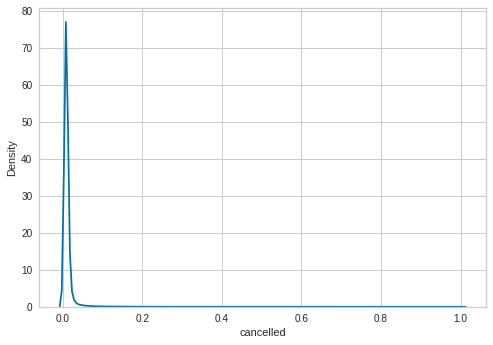

In [71]:
sns.kdeplot(submission_df['cancelled'])

In [72]:
(submission_df['cancelled']==1).value_counts()

False    144776
True         68
Name: cancelled, dtype: int64

In [73]:
submission_df.to_csv('submission.csv',index=False)